In [2]:
import time
import torch
import torchvision.models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
BATCH_SIZE = 3
EPOCHS = 8
DEVICE = torch.device("cuda:0")
N_CLASSES = 1000
LEAF_CLASS = 1

In [4]:
#torch.multiprocessing.set_start_method('spawn')

In [5]:
import os
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

class LeafClassificationDataset(Dataset):
    def __init__(self, dir, transforms=None, default_label=1, apply_mask=False, mask_dir=None):
        self.file_names = [file for file in os.listdir(dir) if os.path.isfile(os.path.join(dir, file)) and file.endswith(("jpg", "jpeg", "png"))]
        self.files = [os.path.join(dir, file) for file in os.listdir(dir) if os.path.isfile(os.path.join(dir, file)) and file.endswith(("jpg", "jpeg", "png"))]
        self.transforms = transforms
        self.default_label = default_label
        self.apply_mask = apply_mask
        self.mask_dir = mask_dir
        if apply_mask and mask_dir is None:
            raise "When apply__mask is True, mask_dir needs to be set"

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = read_image(self.files[idx])
        
        if self.apply_mask:
            mask_file = os.path.join(self.mask_dir, self.file_names[idx])
            mask = read_image(mask_file, ImageReadMode.GRAY)
            mask = mask > 0
            image = image * mask
        
        label = self.default_label
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [6]:
class BinaryWrapper(Dataset):
    def __init__(self, source_dataset):
        self.source_dataset = source_dataset

    def __len__(self):
        return len(self.source_dataset)

    def __getitem__(self, idx):
        image, _ = self.source_dataset[idx]
        return image, 0

In [7]:
import random

tf_simple = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((512, 512))
])
leaf_dataset = LeafClassificationDataset("_data/urban_street0_25/images", 
                                         transforms=tf_simple, 
                                         default_label=LEAF_CLASS, 
                                         apply_mask=False,
                                         mask_dir="_data/urban_street0_25/leaf_instances")

tf_tt_simple = transforms.Compose([
    transforms.ToTensor(),
    tf_simple
])

places_dataset = torchvision.datasets.Places365(
                    "_data/places365", 
                    download=False,
                    small=True,
                    transform=tf_tt_simple)
# Create a subset
places_subset_size = 7_000  # Or any number you prefer
places_indices = random.sample(range(len(places_dataset)), places_subset_size)
places_subset = torch.utils.data.Subset(places_dataset, places_indices)

naturalist_dataset = torchvision.datasets.INaturalist(
                        root="_data/inaturalist",
                        version="2021_train_mini",
                        target_type="class",
                        transform=tf_tt_simple,
                        download=False)
# Create a subset
naturalist_subset_size = 5_000  # Or any number you prefer
naturalist_indices = random.sample(range(len(naturalist_dataset)), naturalist_subset_size)
naturalist_subset = torch.utils.data.Subset(naturalist_dataset, naturalist_indices)

#non_leaf_dataset = torch.utils.data.ConcatDataset([places_subset, naturalist_subset])
non_leaf_dataset = places_subset
classification_dataset = BinaryWrapper(non_leaf_dataset)
print(len(non_leaf_dataset), len(classification_dataset))

dataset = torch.utils.data.ConcatDataset([leaf_dataset, classification_dataset])
print(len(dataset))

def collate_fn(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs), torch.tensor(ys)

dataloader = DataLoader(dataset,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        num_workers=2,
                        collate_fn=collate_fn,
                        pin_memory=True,
                        prefetch_factor=25)

7000 7000
10261


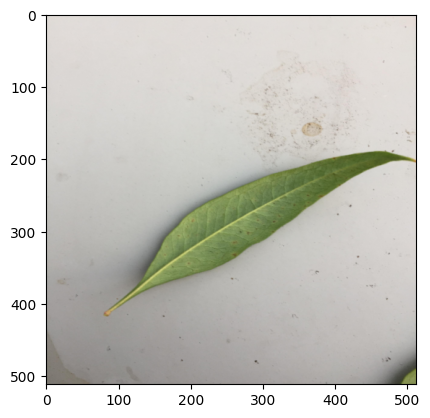

In [8]:
import matplotlib.pyplot as plt
import random
plt.imshow(leaf_dataset[635][0].permute(1,2,0))
plt.show()

In [9]:
import timm
#model = torchvision.models.convnext_base(weights="DEFAULT", num_classes=N_CLASSES)
MODEL_NAME = "convnext_base"
model = timm.create_model(MODEL_NAME, pretrained=True)
num_ftrs = model.head.fc.in_features
model.head.fc = torch.nn.Linear(num_ftrs, 2)

model = model.to(DEVICE)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
import pandas as pd
df_loss = pd.DataFrame({}, columns=["step", "epoch", "loss", "probability"])

In [12]:
tf_net = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(.5),
    transforms.RandomPerspective(distortion_scale=0.6)
).to(DEVICE)

In [13]:
model_total = torch.nn.Sequential(tf_net, model).to(DEVICE)

In [14]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           6,272
       LayerNorm2d-2        [-1, 128, 128, 128]             256
          Identity-3        [-1, 128, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]           6,400
         LayerNorm-5        [-1, 128, 128, 128]             256
            Linear-6        [-1, 128, 128, 512]          66,048
              GELU-7        [-1, 128, 128, 512]               0
           Dropout-8        [-1, 128, 128, 512]               0
          Identity-9        [-1, 128, 128, 512]               0
           Linear-10        [-1, 128, 128, 128]          65,664
          Dropout-11        [-1, 128, 128, 128]               0
              Mlp-12        [-1, 128, 128, 128]               0
         Identity-13        [-1, 128, 128, 128]               0
         Identity-14        [-1, 128, 1

In [16]:
import tqdm
step = 0
running_loss = .0
for epoch in range(EPOCHS):
    data_iter = iter(dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ]  # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    p_bar = tqdm.tqdm(range(len(dataloader)))

    for i in p_bar:
        batch = next_batch 
        step += len(batch)
        if i + 2 != len(dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        # training code
        step += len(batch)
        inputs, labels = batch

        optimizer.zero_grad()

        outputs = model_total(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, LEAF_CLASS].detach().cpu().numpy()
        p_bar.set_description(f"Loss: {loss.item()}, Probabilities: {probs}")
        df_loss.loc[len(df_loss)] = {"step": step, "epoch": epoch, "loss": loss.item(), "probability": probs.mean()}
    print(f"Epoch {epoch} Loss: ", running_loss)
    print("Saving Model Checkpoint")
    torch.save(model, f"out/resnet_leaf_classifier/ckpt_{MODEL_NAME}_{epoch}.pt")
    df_loss.to_csv(f"out/resnet_leaf_classifier/loss_{MODEL_NAME}.csv")
    
print("Finished Training, Saving Model")
torch.save(model, f"out/resnet_leaf_classifier/{time.time()}.pt")

Loss: 2.996019429701846e-05, Probabilities: [7.9829748e-05 7.3230372e-06 2.7463243e-06]: 100%|██████████| 3421/3421 [08:28<00:00,  6.72it/s]    


Epoch 0 Loss:  152.1717537099309
Saving Model Checkpoint


Loss: 6.591725832549855e-05, Probabilities: [7.3760666e-06 1.8075781e-04 9.5109890e-06]: 100%|██████████| 3421/3421 [08:29<00:00,  6.72it/s]    


Epoch 1 Loss:  177.19752142717567
Saving Model Checkpoint


Loss: 0.0001496976474300027, Probabilities: [1.2430283e-05 1.8624891e-05 4.1800155e-04]: 100%|██████████| 3421/3421 [08:29<00:00,  6.71it/s]    


Epoch 2 Loss:  194.99387036616977
Saving Model Checkpoint


Loss: 1.064919797499897e-05, Probabilities: [1.9285893e-07 9.9996853e-01 9.9999976e-01]: 100%|██████████| 3421/3421 [08:29<00:00,  6.71it/s]    


Epoch 3 Loss:  206.6721995502809
Saving Model Checkpoint


Loss: 1.1523557077453006e-06, Probabilities: [9.9999881e-01 5.5480115e-07 1.6910178e-06]: 100%|██████████| 3421/3421 [08:30<00:00,  6.71it/s]   


Epoch 4 Loss:  208.49853277715593
Saving Model Checkpoint


Loss: 0.006255824584513903, Probabilities: [1.8588847e-02 9.9999654e-01 2.5355257e-07]: 100%|██████████| 3421/3421 [08:30<00:00,  6.71it/s]     


Epoch 5 Loss:  213.1609549643734
Saving Model Checkpoint


Loss: 1.1920928244535389e-07, Probabilities: [1.4482194e-07 2.3339739e-07 3.7185409e-08]: 100%|██████████| 3421/3421 [08:29<00:00,  6.71it/s]   


Epoch 6 Loss:  229.45643444889137
Saving Model Checkpoint


Loss: 0.00033968911156989634, Probabilities: [9.9987960e-01 8.5764049e-07 8.9738297e-04]: 100%|██████████| 3421/3421 [08:30<00:00,  6.70it/s]   


Epoch 7 Loss:  236.3857283978903
Saving Model Checkpoint
Finished Training, Saving Model


In [ ]:
df_loss.to_csv(f"out/resnet_leaf_classifier/loss_{MODEL_NAME}_{time.time()}.csv")

In [ ]:
torch.save(model, f"out/resnet_leaf_classifier/{time.time()}.pt")

In [ ]:
model = torch.load("out/resnet_leaf_classifier/1724106037.4204242.pt")

In [17]:
import numpy as np
def show_anns(anns,colors=None):
    if len(anns) == 0:
        return
    if colors is not None:
        sorted_anns, sorted_colors = sorted(zip(anns, colors), key=(lambda x, y: x['area']), reverse=True)
    else:
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    if colors is not None:
        for ann in zip(sorted_anns, sorted_colors):
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    else:
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    ax.imshow(img)

In [18]:
import numpy as np
def show_anns_prob(anns, key):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([[ann[key]] * 3, [0.85]])
        img[m] = color_mask
    ax.imshow(img)

In [202]:
PROB_THRESHOLD = .85

In [20]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [30]:
import random
import os
import cv2
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [41]:
masks = mask_generator.generate(image)
print(f"Detected {len(masks)} areas")

Detected 135 areas


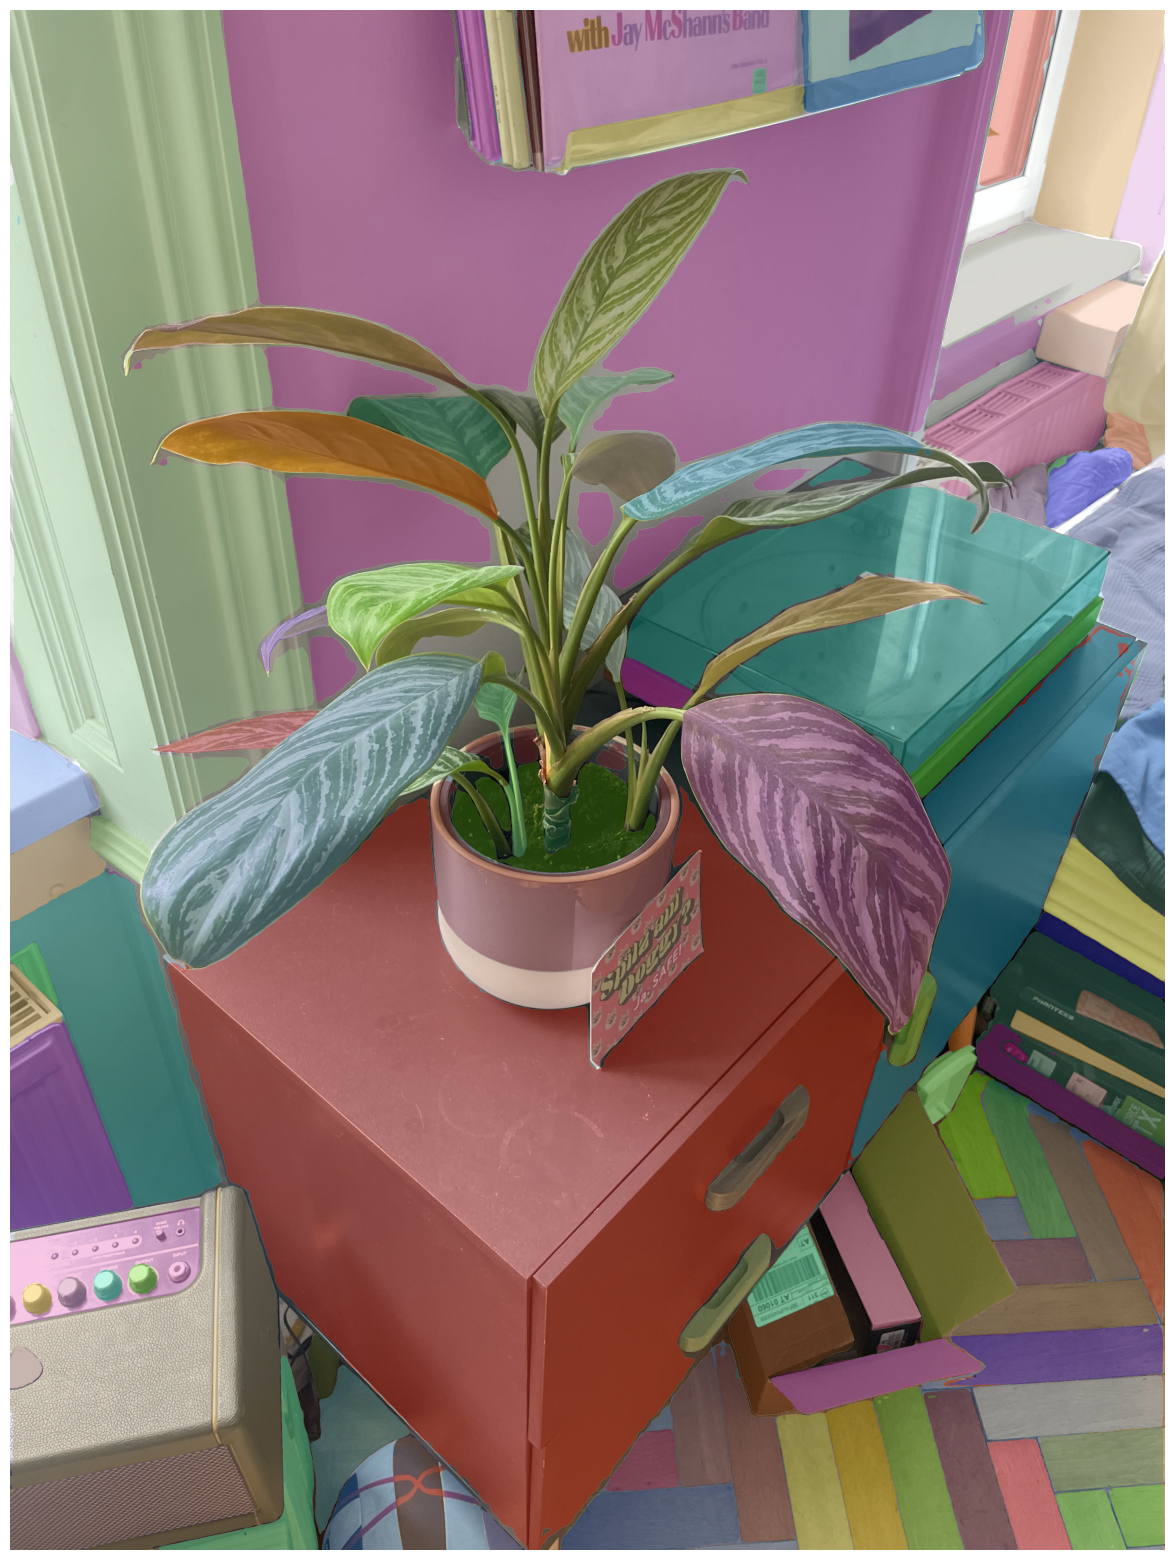

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

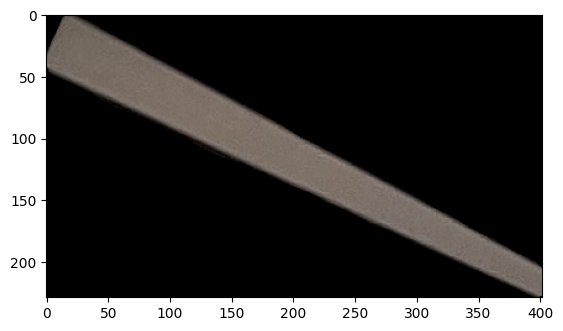

In [292]:
mask_sample = random.sample(masks, k=1)[0]
bbox = mask_sample["bbox"]
image_mask = image * mask_sample["segmentation"][:,:, np.newaxis]
patch = image_mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
plt.imshow(patch)
plt.show()

In [207]:
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  
])

leaf_masks = []
masks_c = []

for mask in masks:
    bbox = mask["bbox"]
    if bbox[2] - bbox[0] == 0 or  bbox[3] - bbox[1] == 0:
        continue
    image_mask = image * mask["segmentation"][:,:, np.newaxis]
    crop = image[bbox[1]:bbox[1] + bbox[3], 
                 bbox[0]:bbox[0]+bbox[2], :]
    if crop.shape[0] == 0 or crop.shape[1] == 0:
        continue
    crop = tf(crop)
    crop = crop.unsqueeze(0)
    crop = crop.to(DEVICE)
    result = model(crop)
    probabilities = torch.nn.functional.softmax(result[0], dim=0)
    mask["leaf_probability"] = probabilities[LEAF_CLASS].detach().cpu().item()
    masks_c.append(mask)
    if probabilities[LEAF_CLASS] > PROB_THRESHOLD:
        leaf_masks.append(mask)
print(f"Detected {len(leaf_masks)} leaf areas")

Detected 2 leaf areas


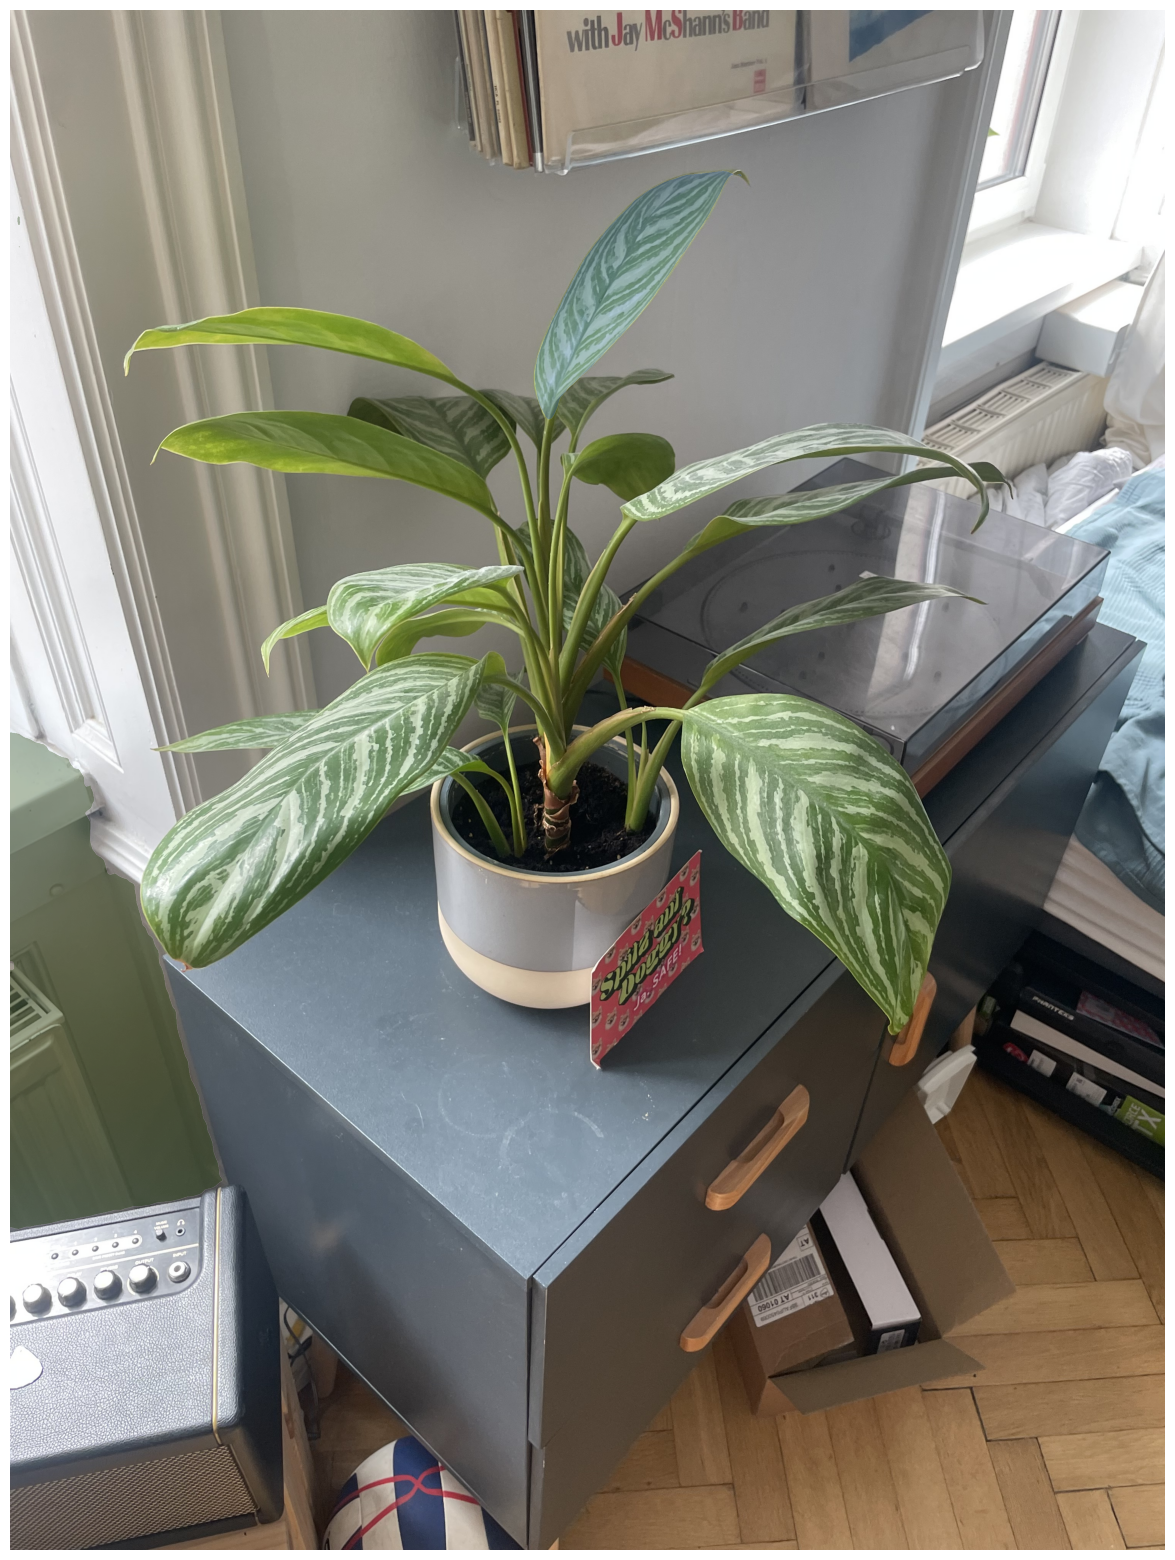

In [204]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(leaf_masks)
plt.axis('off')
plt.show() 

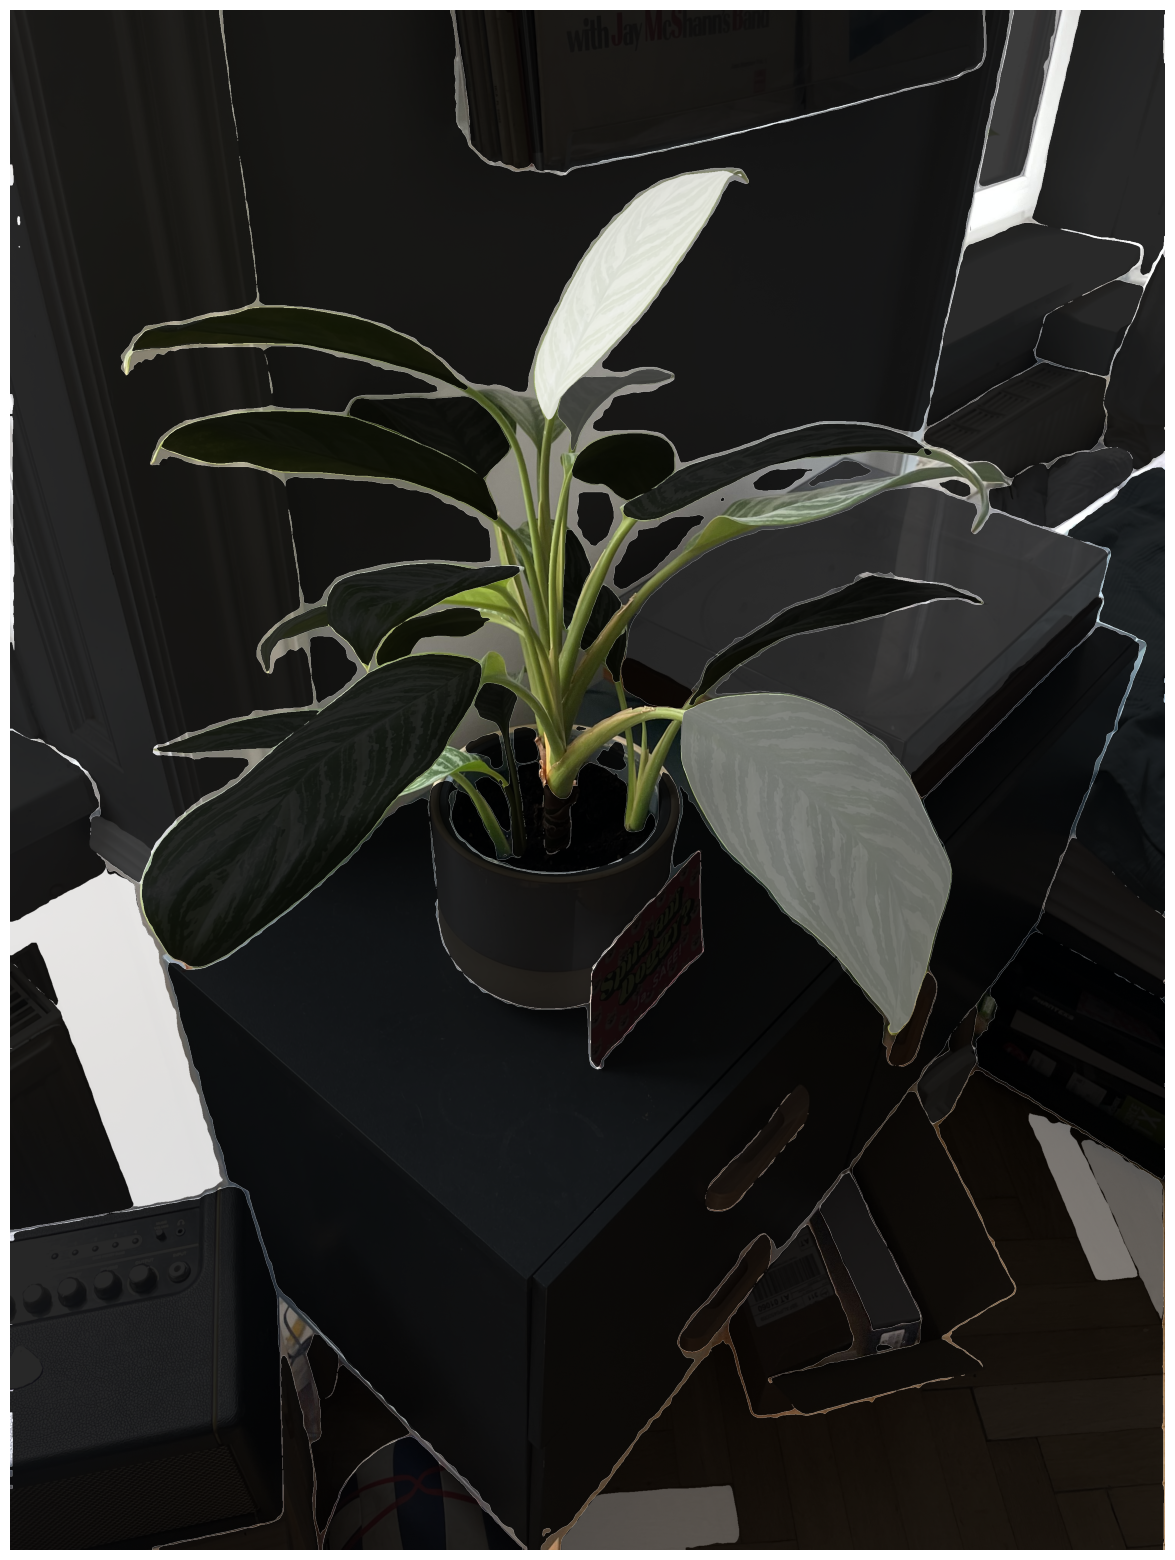

In [205]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns_prob(masks_c, "leaf_probability")
plt.axis('off')
plt.show() 